## Sympy Testing

In [2]:
from sympy import *
v1, v2, v3, vdot1, vdot2, vdot3 = symbols('v1 v2 v3 vdot1 vdot2 vdot3', real=True)
w1, w2, w3, wdot1, wdot2, wdot3 = symbols('w1 w2 w3 wdot1 wdot2 wdot3', real=True)
alpha, beta, sigma = symbols('alpha beta sigma', real=True)
m = symbols('m', real=True, positive=True)

v = Matrix([v1, v2, v3])
vdot = Matrix([vdot1, vdot2, vdot3])
w = Matrix([w1, w2, w3])
wdot = Matrix([wdot1, wdot2, wdot3])

rhat = Matrix([-sin(alpha)*cos(beta), -sin(alpha)*cos(sigma), cos(alpha)])
x = Matrix([1, 0, 0])
y = Matrix([0, 1, 0])
z = Matrix([0, 0, 1])

r = (v.norm())**3 / ((v.cross(vdot)).norm())
ac = v.norm()**2 / r * rhat

at = vdot - ac
eqn = (at.dot(z) / (at.norm() * z.norm()))
eq = Eq(eqn, cos(alpha))
# solve(eqn, alpha)
eq.simplify()

Eq(cos(alpha), (vdot3*sqrt(v1**2 + v2**2 + v3**2) - sqrt((v1*vdot2 - v2*vdot1)**2 + (v1*vdot3 - v3*vdot1)**2 + (v2*vdot3 - v3*vdot2)**2)*cos(alpha))/sqrt((vdot1*sqrt(v1**2 + v2**2 + v3**2) + sqrt((v1*vdot2 - v2*vdot1)**2 + (v1*vdot3 - v3*vdot1)**2 + (v2*vdot3 - v3*vdot2)**2)*sin(alpha)*cos(beta))**2 + (vdot2*sqrt(v1**2 + v2**2 + v3**2) + sqrt((v1*vdot2 - v2*vdot1)**2 + (v1*vdot3 - v3*vdot1)**2 + (v2*vdot3 - v3*vdot2)**2)*sin(alpha)*cos(sigma))**2 + (vdot3*sqrt(v1**2 + v2**2 + v3**2) - sqrt((v1*vdot2 - v2*vdot1)**2 + (v1*vdot3 - v3*vdot1)**2 + (v2*vdot3 - v3*vdot2)**2)*cos(alpha))**2))

In [3]:
eq.simplify()

KeyboardInterrupt: 

In [4]:
f = (eqn - cos(alpha))
print(f)
eqn.simplify()

(vdot3 - sqrt((v1*vdot2 - v2*vdot1)**2 + (v1*vdot3 - v3*vdot1)**2 + (v2*vdot3 - v3*vdot2)**2)*cos(alpha)/sqrt(v1**2 + v2**2 + v3**2))/sqrt(Abs(vdot1 + sqrt((v1*vdot2 - v2*vdot1)**2 + (v1*vdot3 - v3*vdot1)**2 + (v2*vdot3 - v3*vdot2)**2)*sin(alpha)*cos(beta)/sqrt(v1**2 + v2**2 + v3**2))**2 + Abs(vdot2 + sqrt((v1*vdot2 - v2*vdot1)**2 + (v1*vdot3 - v3*vdot1)**2 + (v2*vdot3 - v3*vdot2)**2)*sin(alpha)*cos(sigma)/sqrt(v1**2 + v2**2 + v3**2))**2 + Abs(vdot3 - sqrt((v1*vdot2 - v2*vdot1)**2 + (v1*vdot3 - v3*vdot1)**2 + (v2*vdot3 - v3*vdot2)**2)*cos(alpha)/sqrt(v1**2 + v2**2 + v3**2))**2) - cos(alpha)


(vdot3*sqrt(v1**2 + v2**2 + v3**2) - sqrt((v1*vdot2 - v2*vdot1)**2 + (v1*vdot3 - v3*vdot1)**2 + (v2*vdot3 - v3*vdot2)**2)*cos(alpha))/sqrt((vdot1*sqrt(v1**2 + v2**2 + v3**2) + sqrt((v1*vdot2 - v2*vdot1)**2 + (v1*vdot3 - v3*vdot1)**2 + (v2*vdot3 - v3*vdot2)**2)*sin(alpha)*cos(beta))**2 + (vdot2*sqrt(v1**2 + v2**2 + v3**2) + sqrt((v1*vdot2 - v2*vdot1)**2 + (v1*vdot3 - v3*vdot1)**2 + (v2*vdot3 - v3*vdot2)**2)*sin(alpha)*cos(sigma))**2 + (vdot3*sqrt(v1**2 + v2**2 + v3**2) - sqrt((v1*vdot2 - v2*vdot1)**2 + (v1*vdot3 - v3*vdot1)**2 + (v2*vdot3 - v3*vdot2)**2)*cos(alpha))**2)

## Control Code

In [26]:
from sympy import *
from sympy.algebras.quaternion import Quaternion
import numpy as np
import pandas as pd
import os

class Controls:
    def __init__(
            self,
            t_motor_burnout: float = 1.971,
            t_estimated_apogee: float = 13.571,
            t_launch_rail_clearance: float = 0.164,
            dt: float = 0.01,
            K: np.ndarray = None,
            L: np.ndarray = None,
            x0 = None,
            u0 = None
        ):
        """Initialize the Controls class. Rocket body axis is aligned with y-axis.

        Args:
            t_motor_burnout (float, optional): Time until motor burnout in seconds. Defaults to 1.971.
            t_estimated_apogee (float, optional): Estimated time until apogee in seconds. Defaults to 13.571.
            t_launch_rail_clearance (float, optional): Time until launch rail clearance in seconds. Defaults to 0.164.
            dt (float, required): Time step for simulation in seconds. Defaults to 0.01.
            K (np.ndarray, required): Gain matrix. Defaults to None.
        """
        self.t_motor_burnout = t_motor_burnout # seconds
        self.t_estimated_apogee = t_estimated_apogee # seconds
        self.t_launch_rail_clearance = t_launch_rail_clearance # seconds
        # self.csv_path = os.path.join(os.path.dirname(__file__), "important_data.csv")
        self.csv_path = "/Users/dsong/Library/CloudStorage/OneDrive-UniversityofIllinois-Urbana/Club Stuff/LRI/FV-Controls/Control/important_data.csv"
        self.A : Matrix = None
        self.B : Matrix = None
        self.C : Matrix = None
        self.f_preburnout : Matrix = None
        self.f_postburnout : Matrix = None
        self.K : np.ndarray = K
        self.L : np.ndarray = L
        self.vars : list = None
        self.f_params : Matrix = None
        self.f_subs : Matrix = None
        self.dt = dt
        self.x0 = np.array(x0, dtype=float) if x0 is not None else None
        self.u0 = np.array(u0, dtype=float) if u0 is not None else None


        # Logging
        self.states = [self.x0]
        self.inputs = [self.u0]
        self.As = []
        self.Bs = []
    
    def getLineOfBestFitTime(self, var: str, n: int = 1):
        """Get the line of best fit for the given data with a polynomial of degree n.

        Args:
            var (str): The variable to fit the line to.
            n (int, optional): The degree of the polynomial to fit. Defaults to 1.

        Returns:
            tuple: A tuple containing the coefficients of the polynomial and its degree.
        """
        # Load the CSV data into a DataFrame
        data = pd.read_csv(self.csv_path)
        t = data["# Time (s)"]
        y = None
        if (var == "mass"):
            y = data["Mass (g)"] / 1000  # Convert to kg
        elif (var == "inertia"):
            y = data["Longitudinal moment of inertia (kg·m²)"]
        else:
            raise ValueError(
                "Invalid variable. Choose from: " \
                "'mass'," \
                "'inertia'. " \
                )

        # Filter data based on motor burnout
        mask = t <= self.t_motor_burnout
        t = t[mask]
        y = y[mask]
        coeffs = np.polyfit(t, y, n)
        return coeffs, n


    def getLineOfBestFitAoA(self, burnout: str, var: str, n: int = 5):
        """Get the line of best fit for the given data with a polynomial of degree n. Choose from "stability margin" or "normal force coeff".

        Args:
            burnout (str): Choose from "pre burnout" or "post burnout".
            var (str): The variable to fit the line to.
            n (int, optional): The degree of the polynomial to fit. Defaults to 5.

        Returns:
            tuple: A tuple containing the coefficients of the polynomial and its degree.
        """
        # Load the CSV data into a DataFrame
        data = pd.read_csv(self.csv_path)
        x = data["Angle of attack (°)"]
        if (var == "stability margin"):
            y = data["Stability margin calibers (​)"]
        else:
            raise ValueError(
                "Invalid variable. Choose from: " \
                "'stability margin'. "
                )

        launch_to_burnout = (data["# Time (s)"] >= self.t_launch_rail_clearance) & (data["# Time (s)"] < self.t_motor_burnout)
        burnout_to_apogee = (data["# Time (s)"] >= self.t_motor_burnout) & (data["# Time (s)"] <= self.t_estimated_apogee)
        if (burnout == "pre burnout"):
            x = x[launch_to_burnout]
            y = y[launch_to_burnout]
        elif (burnout == "post burnout"):
            x = x[burnout_to_apogee]
            y = y[burnout_to_apogee]
        else:
            raise ValueError(
                "Invalid motor_burnout. Choose from: " \
                "'pre burnout', " \
                "'post burnout'. "
                )

        coeffs = np.polyfit(x, y, n)
        return coeffs, n


    def getLineOfBestFitVel(self, var: str, n: int = 2):
        """Get the line of best fit for the given data with a polynomial of degree n.

        Args:
            var (str): The variable to fit the line to.
            n (int, optional): The degree of the polynomial to fit. Defaults to 2.

        Returns:
            tuple: A tuple containing the coefficients of the polynomial and its degree.
        """
        # Load the CSV data into a DataFrame
        # TODO: set data to __init__ for efficiency
        data = pd.read_csv(self.csv_path)
        x = data["Total velocity (m/s)"]
        if (var == "drag force"):
            y = data["Drag force (N)"]
        else:
            raise ValueError(
                "Invalid variable. Choose from: " \
                "'drag force'. "
                )
        launch_to_apogee = (data["# Time (s)"] >= self.t_launch_rail_clearance) & (data["# Time (s)"] <= self.t_estimated_apogee)
        x = x[launch_to_apogee]
        y = y[launch_to_apogee]

        coeffs = np.polyfit(x, y, n)
        return coeffs, n


    def getTimeConstants(self, t: float):
        """Get the constants for the rocket at time t.

        Args:
            t (float): The time in seconds.

        Returns:
            dict: A dictionary containing the fin moments, corrective constants, mass, inertia, drag coeff, and drag force.
        """

        constants = dict()
        I = Matrix([0.004, 0.004, 0.29]) # Post burnout inertia values from OpenRocket, kg*m^2
        m = 2.589  # Post burnout mass from OpenRocket, kg
        T = Matrix([0., 0., 0.])  # N

        motor_burnout = t > self.t_motor_burnout

        # TODO: for added efficiency, only call getLineOfBestFitTime once per variable and store the results
        if not motor_burnout:
            coeffs_mass, degree_mass = self.getLineOfBestFitTime("mass")
            m = sum(coeffs_mass[i] * t**(degree_mass - i) for i in range(degree_mass + 1))

            coeffs_inertia, degree_inertia = self.getLineOfBestFitTime("inertia")
            I[2] = sum(coeffs_inertia[i] * t**(degree_inertia - i) for i in range(degree_inertia + 1))

            times = pd.read_csv(self.csv_path)["# Time (s)"]
            thrust = pd.read_csv(self.csv_path)["Thrust (N)"]
            T[2] = np.interp(t, times, thrust) # Thrust acting in z direction

        constants["inertia"] = I
        constants["mass"] = m
        constants["thrust"] = T
        
        return constants


    def getAileronMoment(self, delta1: Symbol, v3: Symbol):
        """Get the aileron moment based on the aileron angle.

        Args:
            delta1 (float): The aileron angle in radians.

        Returns:
            Matrix: The symbolic moment vector [Mx, My, Mz] function of the aileron angle and rocket's vertical velocity.
        """
        
        M1, M2 = 0, 0
        # Verify later with data points
        M3 = delta1/8 * (-2.21e-09*(v3**3) 
                        + 1.58e-06*(v3**2) 
                        + 4.18e-06*v3 
                        - 0*8.26e-05) # v3 = vertical velocity, Mz = roll moment

        return Matrix([M1, M2, M3])
        # -8.26e-05 + 4.18e-06x + 1.58e-06x^2 + -2.21e-09x^3
    
    def R_BW_from_q(self, qw, qx, qy, qz):
        """Convert a quaternion to a rotation matrix. World to body frame.

        Args:
            qw (float): The scalar component of the quaternion.
            qx (float): The x component of the quaternion.
            qy (float): The y component of the quaternion.
            qz (float): The z component of the quaternion.

        Returns:
            Matrix: The rotation matrix from world to body frame.
        """
        s = (qw**2 + qx**2 + qy**2 + qz**2)**-Rational(1,2) # Normalizing factor
        qw, qx, qy, qz = qw*s, qx*s, qy*s, qz*s # Normalized quaternion components

        xx,yy,zz = qx*qx, qy*qy, qz*qz
        wx,wy,wz = qw*qx, qw*qy, qw*qz
        xy,xz,yz = qx*qy, qx*qz, qy*qz
        return Matrix([
            [1-2*(yy+zz),   2*(xy+wz),   2*(xz-wy)],
            [2*(xy-wz),     1-2*(xx+zz), 2*(yz+wx)],
            [2*(xz+wy),     2*(yz-wx),   1-2*(xx+yy)]
        ])


    def deriveEOM(self, post_burnout: bool):
        """Get the equations of motion for the rocket, derive the A and B matrices at time t.

        Assumptions:
        - Rocket body axis is aligned with z-axis
        - No centrifugal forces are considered to simplify AoA and beta calculations
        - Coefficient of lift is approximated as 2*pi*AoA (thin airfoil theory)
        - Thrust acts only in the z direction of the body frame
        - No wind or atmospheric disturbances are considered
        - Density of air is constant at 1.225 kg/m^3

        Notes:
        - The state vector is [w1, w2, w3, v1, v2, v3, qw, qx, qy, qz] where w is angular velocity, v is linear velocity, and q is the quaternion.
        - The input vector is [delta1] where delta1 is the aileron angle
        - Thrust, mass, and inertia are time-varying based on the motor burn state
        - Normal force coefficient Cn is modeled as a polynomial function of velocity, with different coefficients pre- and post-motor burnout
        - Drag force Fd is modeled as a quadratic function of velocity magnitude
        - Lift force Fl is modeled using thin airfoil theory, proportional to angle of attack (AoA)
        - Corrective moment coefficient C is modeled as a function of velocity magnitude, normal force coefficient Cn, stability margin SM, and rocket diameter
        - Normal force coefficient derivative Cnalpha is modeled as Cn * (AoA / (AoA^2 + aoa_eps^2)) to ensure smoothness at AoA = 0
        - Stability margin SM is modeled as a polynomial function of AoA
        - Small terms are added to avoid division by zero in velocity magnitude and AoA calculations (denoted as eps and aoa_eps)

        Args:
            post_burnout (bool): Whether the rocket is in the post-burnout phase.
        Returns:
            tuple: A tuple containing the A and B Numpy arrays evaluated at the operating state xhat and input u.
        """
        w1, w2, w3, v1, v2 = symbols('w_1 w_2 w_3 v_1 v_2', real = True) # Angular and linear velocities
        v3 = symbols('v_3', real = True, positive = True) # Longitudinal velocity, assumed positive during flight
        qw, qx, qy, qz = symbols('q_w q_x q_y q_z', real = True) # Quaternion components
        I1, I2, I3 = symbols('I_1 I_2 I_3', real = True) # Moments of inertia
        M1, M2, M3 = symbols('M_1 M_2 M_3', real = True) # Moments
        T1, T2, T3 = symbols('T_1 T_2 T_3', real = True) # Thrusts
        mass, rho, A, g = symbols('m rho A g', real = True) # Mass, air density, reference area, gravity
        delta1 = symbols('delta_1', real = True) # Aileron angle

        epsAoA = Float(1e-3)  # Small term to avoid division by zero in AoA calculation
        # AoA = atan2(sqrt(v1**2 + v2**2), v3 + epsAoA) # Angle of attack
        AoA_raw = atan2(sqrt(v1**2 + v2**2), v3 + epsAoA)
        AoA = AoA_raw                               # keep for directions
        AoA_eff = Piecewise(                        # bounded for lift/derivatives
            (0,   Abs(AoA_raw) <= 0),
            (Min(Abs(AoA_raw), rad(20)) * (AoA_raw/Abs(AoA_raw)), True)  # ±20°
        )

        eps = Float(1e-3)  # Small term to avoid division by zero
        v = Matrix([v1, v2, v3]) # Velocity vector
        v_mag = sqrt(v1**2 + v2**2 + v3**2 + eps**2) # Magnitude of velocity with small term to avoid division by zero
        vhat = v / v_mag  # Unit vector in direction of velocity

        ## Thrust ##
        T : Matrix = Matrix([T1, T2, T3])  # Thrust vector, T1 and T2 are assumed 0

        ## Gravity ##
        Fg_world = Matrix([0.0, 0.0, -mass * g])
        R_world_to_body = self.R_BW_from_q(qw, qx, qy, qz)  # Rotation matrix from world to body frame
        Fg : Matrix = R_world_to_body * Fg_world  # Transform gravitational force to body frame

        ## Drag Force ##
        Fd_mag = -(0.627 + -0.029*v_mag + 1.95e-3*v_mag**2) # Drag force approximation
        Fd : Matrix = Fd_mag * vhat # Drag force vector

        ## Lift Force ##
        eps_beta = Float(1e-3)
        nan_guard = sqrt(v1**2 + v2**2 + eps_beta**2)
        beta = 2 * atan2(v2, nan_guard + v1) # Equivalent to atan2(v2, v1) but avoids NaN at (0,0)
        L = 1/2 * rho * v_mag**2 * (2 * pi * AoA) * A # Lift force approximation
        nL = Matrix([
            -cos(AoA) * cos(beta),
            -cos(AoA) * sin(beta),
            sin(AoA)
        ]) # Lift direction unit vector
        Fl : Matrix = L * nL # Lift force vector

        ## Total Forces ##
        F = T + Fd + Fl + Fg # Total force vector

        ## Normal force coefficient ##
        Cn = None
        if not post_burnout:
            Cn = 28 + -3.49*v_mag + 0.236*v_mag**2 + -9.81E-03*v_mag**3 + 2.57E-04*v_mag**4 + -4.35E-06*v_mag**5 + 4.77E-08*v_mag**6 + -3.39E-10*v_mag**7 + 1.49E-12*v_mag**8 + -3.73E-15*v_mag**9 + 4.02E-18*v_mag**10
        else:
            Cn = -11.2 + 2.35*v_mag + -0.183*v_mag**2 + 7.59E-03*v_mag**3 + -1.9E-04*v_mag**4 + 3.04E-06*v_mag**5 + -3.2E-08*v_mag**6 + 2.2E-10*v_mag**7 + -9.47E-13*v_mag**8 + 2.33E-15*v_mag**9 + -2.5E-18*v_mag**10

        ## Cnalpha ##
        # Cnalpha = Piecewise(
        #     (0, Abs(AoA) < epsAoA),                                  # inside deadband
        #     (Cn * (AoA / (AoA**2 + epsAoA**2)), True)                # otherwise
        # )

        Cnalpha = Piecewise(
            (0, Abs(AoA_eff) <= epsAoA),
            (Cn * (AoA_eff / (AoA_eff**2 + epsAoA**2)), True)
        )
            
        ## Stability Margin ##
        AoA_deg = AoA * 180 / pi # Convert AoA to degrees for polynomial fit
        if not post_burnout:
            SM = 2.8 + -0.48*AoA_deg + 0.163*AoA_deg**2 + -0.0386*AoA_deg**3 + 5.46E-03*AoA_deg**4 + -4.61E-04*AoA_deg**5 + 2.28E-05*AoA_deg**6 + -6.1E-07*AoA_deg**7 + 6.79E-09*AoA_deg**8
        else:
            SM = -0.086*AoA_deg + 2.73

        ## Rocket diameter ##
        d = Float(7.87)/100 # m

        ## Corrective moment coefficient ##
        # C = v_mag**2 * A * Cnalpha * (SM * d) * rho / 2
        C_raw = v_mag**2 * A * Cnalpha * (SM * d) * rho / 2
        C = Piecewise(
            (0, C_raw <= 0),                                     # never excite lateral axes
            (Min(C_raw, Float(5e-2)), True)                      # cap magnitude (tune)
        )

        ## Moment due to aileron deflection ##
        M_fin = 0*Matrix([0.003, 0.003, 0.003])  # Fin misalignment from open rocket
        M_delta = self.getAileronMoment(delta1, v3)
        M1 = M_fin[0] + M_delta[0]
        M2 = M_fin[1] + M_delta[1]
        M3 = M_fin[2] + M_delta[2]

        ## Quaternion kinematics ##
        S = Matrix([[0, -w3, w2],
                    [w3, 0, -w1],
                    [-w2, w1, 0]])
        q_vec = Matrix([qw, qx, qy, qz])
        Omega = Matrix([
            [0, -w1, -w2, -w3],
            [w1, 0, w3, -w2],
            [w2, -w3, 0, w1],
            [w3, w2, -w1, 0]
        ])
        
        # -------------------------------------------- #

        ## Equations of motion ##
        w1dot = ((I2 - I3) * w2 * w3 - C * w1 + M1) / I1
        w2dot = ((I3 - I1) * w3 * w1 - C * w2 + M2) / I2
        w3dot = ((I1 - I2) * w1 * w2 + M3) / I3
        vdot = F/mass - S * v
        qdot = (Omega * q_vec) * Float(1/2)

        f = Matrix([
            [w1dot],
            [w2dot],
            [w3dot],
            [vdot[0]],
            [vdot[1]],
            [vdot[2]],
            [qdot[0]],
            [qdot[1]],
            [qdot[2]],
            [qdot[3]]
        ])
        vars = [w1, w2, w3, v1, v2, v3, qw, qx, qy, qz, delta1, I1, I2, I3, T1, T2, T3, mass, rho, A, g]

        self.vars = vars
        if (not post_burnout):
            self.f_preburnout = f
        else:
            self.f_postburnout = f
    

    def computeAB(self, t: float, xhat: np.array, u: np.array):
        """Compute the A and B matrices at time t.
        Args:
            t (float): The time in seconds.
            xhat (np.array): The state estimation vector as a numpy array.
            u (np.array): The input vector as a numpy array.
        Returns:
            tuple: A tuple containing the symbolic f matrix, f evaluated at the operating state xhat and input u, and the A and B matrices evaluated at the operating state xhat and input u.
        """
        if self.f_preburnout is None or self.f_postburnout is None or self.vars is None:
            print("Equations of motion have not been derived yet. Call deriveEOM() first on pre- and post-burnout.")
            return None, None, None, None
        
        w1, w2, w3, v1, v2, v3, qw, qx, qy, qz, delta1, I1, I2, I3, T1, T2, T3, mass, rho, A, g = self.vars

        m = Matrix([w1, w2, w3, v1, v2, v3, qw, qx, qy, qz]) # State vector
        n = Matrix([delta1]) # Input vector

        ## Get time varying constants ##
        constants = self.getTimeConstants(t)
        mass_rocket = constants["mass"]
        inertia = constants["inertia"]
        thrust = constants["thrust"]

        params = {
            I1: Float(inertia[0]), # Ixx
            I2: Float(inertia[1]), # Iyy
            I3: Float(inertia[2]), # Izz
            T1: thrust[0],
            T2: thrust[1],
            T3: thrust[2],
            mass: Float(mass_rocket),
            rho: Float(1.225), # kg/m^3 temp constant rho
            A: pi * Float((7.87/100/2)**2), # m^2 reference area
            g: Float(9.81), # m/s^2
        }

        ## Select pre- or post-burnout equations ##
        preburnout = t <= self.t_motor_burnout
        postburnout = t > self.t_motor_burnout
        f_params = None
        if preburnout:
            f_params = self.f_preburnout.subs(params)
        elif postburnout:
            f_params = self.f_postburnout.subs(params)

        ## Replace sqrt(v1^2 + v2^2) with a non-zero term to avoid NaNs in A matrix ##
        eps = Float(1e-3)  # Small term to avoid division by zero
        vxy = sqrt(v1**2 + v2**2 + eps**2)
        repl = {
            sqrt(v1**2 + v2**2): vxy,
            (v1**2 + v2**2)**Float(1)/2: vxy
        }
        f_params = f_params.xreplace(repl)

        ## NOTE: Not finding equilibrium states, using trajectory/operating-point linearization
        m_e = {
            w1: xhat[0],
            w2: xhat[1],
            w3: xhat[2],
            v1: xhat[3],
            v2: xhat[4],
            v3: xhat[5],
            qw: xhat[6],
            qx: xhat[7],
            qy: xhat[8],
            qz: xhat[9],
        }

        n_e = {
            delta1: u[0],
        }

        f_subs = f_params.subs(m_e).subs(n_e)

        A = f_params.jacobian(m).subs(m_e).subs(n_e)
        B = f_params.jacobian(n).subs(m_e).subs(n_e)

        self.A = A
        self.B = B
        self.f_params = f_params
        self.f_subs = f_subs

        ## Logging ##
        self.As.append(A)
        self.Bs.append(B)


    def setK(self, K: np.ndarray):
        """Set the gain matrix K.

        Args:
            K (np.ndarray): The gain matrix.
        """
        self.K = K


    def computeC(self, xhat: np.ndarray, u: np.ndarray):
        """Compute the control input based on the current state, estimated state, and gain matrix.

        Args:
            xhat (np.ndarray): The estimated state vector.
            u (np.ndarray): The current input vector.
        
        Returns:
            np.ndarray: The computed control input vector.
        """
        w1, w2, w3 = self.vars[0], self.vars[1], self.vars[2]
        v1, v2, v3 = self.vars[3], self.vars[4], self.vars[5]
        qw, qx, qy, qz = self.vars[6], self.vars[7], self.vars[8], self.vars[9]
        delta1 = self.vars[10]

        m = Matrix([w1, w2, w3, v1, v2, v3, qw, qx, qy, qz])
        
        g = Matrix([
            [w1],
            [w2],
            [w3],
            [qw],
            [qx],
            [qy],
            [qz]
        ])

        m_e = {
            w1: xhat[0],
            w2: xhat[1],
            w3: xhat[2],
            v1: xhat[3],
            v2: xhat[4],
            v3: xhat[5],
            qw: xhat[6],
            qx: xhat[7],
            qy: xhat[8],
            qz: xhat[9],
        }

        n_e = {
            delta1: u[0],
        }

        C = g.jacobian(m).subs(m_e).subs(n_e)
        self.C = C


    def setL(self, L: np.ndarray):
        """Set the observer gain matrix L.

        Args:
            L (np.ndarray): The observer gain matrix.
        """
        self.L = L


    def buildL(self, lw3=20.0, lqw=5.0, lqx=5.0, lqy=5.0, lqz=10.0):
        """
        Hand-tuned observer gain L (10x7) for x=[v(3), w(3), q(4)], y=[w(3), q(4)].
        - Only w3 row uses the w3 residual.
        - Quaternion rows use quaternion residuals; roll-weight lqz can be larger.
        - All velocity rows are zero to avoid injecting measurement noise into v.

        Args:
            lw3 (float): Gain for w3 residual into w3 state.
            lqw (float): Gain for qw residual into qw state.
            lqx (float): Gain for qx residual into qx state.
            lqy (float): Gain for qy residual into qy state.
            lqz (float): Gain for qz residual into qz state.

        Returns:
            np.ndarray: The observer gain matrix L.
        """
        L = np.zeros((10, 7))

        # w3 <- r_w3
        L[5, 2] = lw3

        # quaternion <- r_quaternion
        L[6, 3] = lqw   # qw residual into qw state
        L[7, 4] = lqx   # qx residual into qx state
        L[8, 5] = lqy   # qy residual into qy state
        L[9, 6] = lqz   # qz residual into qz state (roll-heavy)

        self.L = L


    def quat_to_euler_xyz(self, q: np.ndarray, degrees=False, eps=1e-9):
        """
        Convert quaternion [w, x, y, z] to Euler angles (theta, phi, psi)
        using the intrinsic XYZ convention:
            theta: rotation about x (pitch)
            phi:   rotation about y (yaw)
            psi:   rotation about z (roll)
        Such that: R = Rz(psi) @ Ry(phi) @ Rx(theta)

        Args:
            q (array-like): Quaternion [w, x, y, z].
            degrees (bool): If True, return angles in degrees. (default: radians)
            eps (float):    Small epsilon to handle numerical edge cases.

        Returns:
            (theta, phi, psi): tuple of floats
        """
        # normalize to be safe
        n = np.linalg.norm(q)
        if n < eps:
            raise ValueError("Zero-norm quaternion")
        w = q[0] / n
        x = q[1] / n
        y = q[2] / n
        z = q[3] / n

        # Rotation matrix from quaternion (world<-body)
        # R[i,j] = row i, column j
        xx, yy, zz = x*x, y*y, z*z
        wx, wy, wz = w*x, w*y, w*z
        xy, xz, yz = x*y, x*z, y*z

        R = np.array([
            [1 - 2*(yy + zz),   2*(xy - wz),       2*(xz + wy)],
            [2*(xy + wz),       1 - 2*(xx + zz),   2*(yz - wx)],
            [2*(xz - wy),       2*(yz + wx),       1 - 2*(xx + yy)]
        ])

        # Extract for intrinsic XYZ (q = qz(psi) ⊗ qy(phi) ⊗ qx(theta))
        # From R = Rz(psi) Ry(phi) Rx(theta):
        #   phi   = asin(-R[2,0])
        #   theta = atan2(R[2,1], R[2,2])
        #   psi   = atan2(R[1,0], R[0,0])
        #
        # Handle numerical drift by clamping asin argument.
        s = -R[2, 0]
        s = np.clip(s, -1.0, 1.0)
        phi   = np.arcsin(s)
        theta = np.arctan2(R[2, 1], R[2, 2])

        # If cos(phi) ~ 0 (gimbal lock), fall back to a stable computation for psi
        if abs(np.cos(phi)) < eps:
            # At gimbal lock, theta and psi are coupled; choose a consistent psi:
            # Use elements that remain well-defined:
            # when cos(phi) ~ 0, use psi from atan2(-R[0,1], R[1,1])
            psi = np.arctan2(-R[0, 1], R[1, 1])
        else:
            psi = np.arctan2(R[1, 0], R[0, 0])

        if degrees:
            return np.degrees(theta), np.degrees(phi), np.degrees(psi)
        return theta, phi, psi


    def euler_to_quat_xyz(self, theta, phi, psi, degrees=False):
        """
        Convert Euler angles to a quaternion using intrinsic XYZ:
            - theta: rotation about x (pitch)
            - phi:   rotation about y (yaw)
            - psi:   rotation about z (roll)
        Convention: R = Rz(psi) @ Ry(phi) @ Rx(theta)
        Quaternion is returned as [w, x, y, z].

        Args:
            theta, phi, psi : floats (radians by default; set degrees=True if in deg)
            degrees         : if True, inputs are in degrees

        Returns:
            np.ndarray shape (4,) -> [w, x, y, z]
        """
        if degrees:
            theta, phi, psi = np.radians([theta, phi, psi])

        # half-angles
        cth, sth = np.cos(theta/2.0), np.sin(theta/2.0)
        cph, sph = np.cos(phi/2.0),   np.sin(phi/2.0)
        cps, sps = np.cos(psi/2.0),   np.sin(psi/2.0)

        # intrinsic XYZ closed form (q = qz * qy * qx), scalar-first
        qw =  cph*cps*cth + sph*sps*sth
        qx = -sph*sps*cth + sth*cph*cps
        qy =  sph*cps*cth + sps*sth*cph
        qz = -sph*sth*cps + sps*cph*cth

        q = np.array([qw, qx, qy, qz], dtype=float)
        # normalize to guard against numerical drift
        q /= np.linalg.norm(q)
        return q


    def deriveSensorModels(self,t: float,
                           w1: float, w2: float, w3: float,
                           theta: float, phi: float, psi: float):
        """Derive the sensor models for the rocket. Assumes small angles for accelerometer bias calculation. Converts Euler angles to quaternion.

        Args:
            t (float): The time in seconds.
            w1 (float): The angular velocity in the x direction in rad/s.
            w2 (float): The angular velocity in the y direction in rad/s.
            w3 (float): The angular velocity in the z direction in rad/s.
            theta (float): The pitch angle in radians.
            phi (float): The yaw angle in radians.
            psi (float): The roll angle in radians.

        Returns:
            np.array: The sensor measurements as a numpy array. [gx, gy, gz, qw, qx, qy, qz]. Gyro in rad/s, quaternion normalized.
        """

        bg1 = np.deg2rad(20.116124137171195 / 3600) # rad/s
        bg2 = np.deg2rad(28.34293605241209 / 3600) # rad/s
        bg3 = np.deg2rad(25.387227350679243 / 3600) # rad/s

        ARW1 = np.deg2rad(6.6977525311882316 / 60) # rad/sqrt(s)
        ARW2 = np.deg2rad(7.733730273458847 / 60) # rad/sqrt(s)
        ARW3 = np.deg2rad(7.020108147288731 / 60) # rad/sqrt(s)

        sigma_w1 = ARW1 / np.sqrt(self.dt)
        sigma_w2 = ARW2 / np.sqrt(self.dt)
        sigma_w3 = ARW3 / np.sqrt(self.dt)

        gw1 = w1 + bg1 + np.random.normal(0.0, sigma_w1)
        gw2 = w2 + bg2 + np.random.normal(0.0, sigma_w2)
        gw3 = w3 + bg3 + np.random.normal(0.0, sigma_w3)

        sigma_theta = np.deg2rad(0.9840317663439204 / (60)) / np.sqrt(self.dt) # rad
        sigma_phi = np.deg2rad(0.872408877638351 / (60)) / np.sqrt(self.dt) # rad

        sigma_Bx = 0.006669083462481435
        sigma_By = 0.003656134366885892
        Bx = 3.500
        By = 28.500
        sigma_psi = np.sqrt((sigma_Bx * By)**2 + (sigma_By * Bx)**2) / (Bx**2 + By**2)

        b_theta = (287.9041401059671 / (9.81 * 3600)) # rad/s (small-angle a_x/g)
        b_phi = (88.37148088944824 / (9.81 * 3600)) # rad/s (small-angle a_y/g)

        bx = 1.5945108844195712
        by = 0.8536236163450057
        b_psi = np.sqrt((bx * By)**2 + (by * Bx)**2) / (Bx**2 + By**2) / 3600 # rad/s?

        theta_m = theta + b_theta * t + np.random.normal(0.0, sigma_theta)
        phi_m = phi + b_phi * t + np.random.normal(0.0, sigma_phi)
        psi_m = psi + b_psi * t + np.random.normal(0.0, sigma_psi)

        q = self.euler_to_quat_xyz(theta_m, phi_m, psi_m)

        g = np.array([gw1, gw2, gw3, q[0], q[1], q[2], q[3]])

        return g

    def run(self, t: float, xhat: np.array, u: np.array):
        """Run the state estimator recursively until the estimated apogee time is reached.
        Args:
            t (float): The current time in seconds.
            xhat (np.array): The current state estimate as a numpy array.
            u (np.array): The current input as a numpy array.
        Returns:
            np.array: The updated state estimate as a numpy array.
        """
        if self.K is None:
            print("Gain matrix K has not been set. Call setK() first or initialize it in the constructor.")
        if self.L is None:
            print("Observer gain matrix L has not been set. Call setL() first or initialize it in the constructor or call buildL().")
        print(f"xhat: {xhat}")
        ## Compute A and B matrices at current state and input ##
        self.computeAB(t, xhat, u)
        self.computeC(xhat, u)

        ## Convert symbolic matrices to numerical numpy arrays ##
        A = np.array(self.A.n()).astype(np.float64)
        B = np.array(self.B.n()).astype(np.float64)
        C = np.array(self.C.n()).astype(np.float64)

        # self.x0[2] = 0  # Desired roll rate is 0
        # self.x0[5] = xhat[5] # Desired vertical velocity is current vertical velocity
        x_des = self.x0.copy()
        x_des[2] = 0.0
        x_des[5] = float(xhat[5])
        
        u = -self.K @ (xhat - x_des) + self.u0  # State feedback control law
        u = np.clip(u, np.deg2rad(-8), np.deg2rad(8))  # Limit aileron deflection to +/- 8 degrees

        theta, phi, psi = self.quat_to_euler_xyz(xhat[6:10])  # Convert quaternion to Euler angles
        y = self.deriveSensorModels(t, xhat[0], xhat[1], xhat[2],
                                    theta, phi, psi)  # Simulated sensor measurements
        f_subs = np.array(self.f_subs, dtype=float).reshape(-1)
        # d = f_subs - (A @ xhat + B @ u)  # Disturbance/uncertainty term
        # xdot = f_subs - self.L @ (C @ xhat - y)
        xdot = f_subs
        print(f"xdot: {xdot}")

        # v3 = pd.read_csv(self.csv_path)["Vertical velocity (m/s)"]
        # w3 = pd.read_csv(self.csv_path)["Roll rate (°/s)"]
        # times = pd.read_csv(self.csv_path)["# Time (s)"]
        # xhat[5] = np.interp(t, times, v3)  # Update vertical velocity from data for testing
        # if np.isclose(t % 3.0 + self.dt, 0.0, atol=self.dt):
        #     xhat[2] = np.interp(t, times, w3) # Inject roll rate disturbance every 3 seconds for testing
        #     xhat[2] = np.random.uniform(np.deg2rad(-1e-4), np.deg2rad(1e-4)) # Small random disturbance
        #     print(f"Injecting roll rate disturbance: {np.rad2deg(xhat[2]):.6f} deg/s")
        # if (np.isclose(t % 1.0, 0.0, atol=self.dt) & (t > 1.0)):
        #     xhat[0] = np.random.uniform(-1e-2, 1e-2) # Small random disturbance in pitch rate
        #     xhat[1] = np.random.uniform(-1e-2, 1e-2) # Small random disturbance in yaw rate
        #     print(f"Injecting pitch/yaw rate disturbance: p: {np.rad2deg(xhat[0]):.6f} deg/s, r: {np.rad2deg(xhat[1]):.6f} deg/s")
        #     xhat[3] = np.random.uniform(-1e0, 1e0) # Small random disturbance in lateral velocity
        #     xhat[4] = np.random.uniform(-1e0, 1e0) # Small random disturbance in lateral velocity
        #     print(f"Injecting lateral velocity disturbance: v1: {xhat[3]:.6f} m/s, v2: {xhat[4]:.6f} m/s")

        ## Update state estimate ##
        xhat = xhat + xdot * self.dt
        xhat[6:10] /= np.linalg.norm(xhat[6:10])  # Normalize quaternion

        ## Logging ##
        self.states.append(xhat)
        self.inputs.append(u)

        t = t + self.dt
        print(f"t: {t:.3f}")
        return self.run(t, xhat, u) if t < self.t_estimated_apogee else None
    
    def test_run(self, t: float, xhat: np.array, u: np.array):
        """Test run for a single iteration of the state estimator.

        Args:
            t (float): The current time in seconds.
            xhat (np.array): The current state estimate as a numpy array.
            u (np.array): The current input as a numpy array.
        """
        self.computeAB(t, xhat, u)
        print(f"xhat: {xhat}")

        f_subs = np.array(self.f_subs, dtype=float).reshape(-1)
        xdot = f_subs
        print(f"xdot: {xdot}")

        xhat = xhat + xdot * self.dt
        xhat[6:10] /= np.linalg.norm(xhat[6:10])
        
        x_des = self.x0.copy()
        x_des[2] = 0.0
        x_des[5] = float(xhat[5])
        
        u = -self.K @ (xhat - x_des) + self.u0  # State feedback control law
        u = np.clip(u, np.deg2rad(-8), np.deg2rad(8))  # Limit aileron deflection to +/- 8 degrees
        
        ## Logging ##
        self.states.append(xhat)
        self.inputs.append(u)

        t = t + self.dt
        return self.run(t, xhat, u) if t < self.t_estimated_apogee else None
    
    def _f(self, t, x, u):
        # assumes you already called computeAB/computeC to refresh self.f_subs
        f = np.asarray(self.f_subs, float).reshape(-1)
        return f

    def _rk4_step(self, t, x, u):
        dt = self.dt
        k1 = self._f(t,       x,             u)
        k2 = self._f(t+dt/2., x + dt*k1/2.,  u)
        k3 = self._f(t+dt/2., x + dt*k2/2.,  u)
        k4 = self._f(t+dt,    x + dt*k3,     u)
        return x + (dt/6.)*(k1 + 2*k2 + 2*k3 + k4)
    
    def RUNPLS(self, t, xhat: np.array, u: np.array):
        """Runge-Kutta 4th order integration of the state estimator recursively until the estimated apogee time is reached.
        Args:
            t (float): The current time in seconds.
            xhat (np.array): The current state estimate as a numpy array.
            u (np.array): The current input as a numpy array.
        Returns:
            np.array: The updated state estimate as a numpy array.
        """
        # loop, not recursion
        while t < self.t_estimated_apogee:
            self.computeAB(t, xhat, u)  # refresh self.f_subs
            # (optionally compute C, y, and use L for a correction later)
            xhat = self._rk4_step(t, xhat, u)

            # quaternion normalize
            qn = np.linalg.norm(xhat[6:10])
            xhat[6:10] = np.array([1.,0.,0.,0.]) if qn < 1e-12 else xhat[6:10]/qn

            # basic control law (keep small for now)
            x_des = self.x0.copy()
            x_des[2] = 0.0
            x_des[5] = float(xhat[5])
            u = np.clip(-self.K @ (xhat - x_des) + self.u0, np.deg2rad(-8), np.deg2rad(8))

            # log + advance time
            self.states.append(xhat.copy())
            self.inputs.append(u.copy())
            t += self.dt
            print(f"t: {t:.3f}")

    def test_eom(self, t: float, xhat: np.array, u: np.array):
        """Test the equations of motion by computing f_subs at the given state and input.

        Args:
            t (float): The current time in seconds.
            xhat (np.array): The current state estimate as a numpy array.
            u (np.array): The current input as a numpy array.
        """
        while t < self.t_estimated_apogee:
            self.computeAB(t, xhat, u)
            f_subs = np.array(self.f_subs, dtype=float).reshape(-1)
            xhat = xhat + f_subs * self.dt
            xhat[6:10] /= np.linalg.norm(xhat[6:10])
            u = np.clip(-self.K @ (xhat - self.x0) + self.u0, np.deg2rad(-8), np.deg2rad(8))
            self.states.append(xhat)
            self.inputs.append(u)
            t = t + self.dt
            print(f"t: {t:.3f}, xhat: {xhat}, u: {u}")

    def test_AB(self, t: float, xhat: np.array, u: np.array):
        """Test the equations of motion by computing f_subs at the given state and input.

        Args:
            t (float): The current time in seconds.
            xhat (np.array): The current state estimate as a numpy array.
            u (np.array): The current input as a numpy array.
        """
        while t < self.t_estimated_apogee:
            self.computeAB(t, xhat, u)
            A = np.array(self.A.n()).astype(np.float64)
            B = np.array(self.B.n()).astype(np.float64)
            xdot = A @ xhat + B @ u
            xhat = xhat + xdot * self.dt
            xhat[6:10] /= np.linalg.norm(xhat[6:10])
            u = np.clip(-self.K @ (xhat - self.x0) + self.u0, np.deg2rad(-8), np.deg2rad(8))
            self.states.append(xhat)
            self.inputs.append(u)
            t = t + self.dt
            print(f"t: {t:.3f}, xhat: {xhat}, u: {u}")


# TODO: Figure out why when using A and B from self.computeAB never advances the state.
fsubs works and updates the state properly, not sure why nothing is changing for using A and B

In [27]:
## Define gain matrix ##
K = np.zeros((1,10))
K[0][2] = 1000 # Roll rate feedback
K[0][9] = 0.1 # Roll angle feedback

## Define initial conditions ##
t0 = 0.0
xhat0 = np.array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0]) # Initial state estimate
u0 = np.array([0])
controller = Controls(K=K, dt=0.01, x0=xhat0, u0=u0)
controller.deriveEOM(post_burnout=False)
controller.deriveEOM(post_burnout=True)
controller.test_AB(t0, xhat0, u0)

t: 0.010, xhat: [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.], u: [0.]
t: 0.020, xhat: [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.], u: [0.]
t: 0.030, xhat: [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.], u: [0.]
t: 0.040, xhat: [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.], u: [0.]
t: 0.050, xhat: [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.], u: [0.]
t: 0.060, xhat: [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.], u: [0.]
t: 0.070, xhat: [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.], u: [0.]
t: 0.080, xhat: [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.], u: [0.]
t: 0.090, xhat: [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.], u: [0.]
t: 0.100, xhat: [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.], u: [0.]
t: 0.110, xhat: [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.], u: [0.]
t: 0.120, xhat: [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.], u: [0.]
t: 0.130, xhat: [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.], u: [0.]
t: 0.140, xhat: [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.], u: [0.]
t: 0.150, xhat: [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.], u: [0.]
t: 0.160, xhat: [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.], u: [0.]
t: 0.170, xhat: [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.], u: [0.]
t: 0.180, xhat: [0. 0. 0. 0. 0.

KeyboardInterrupt: 

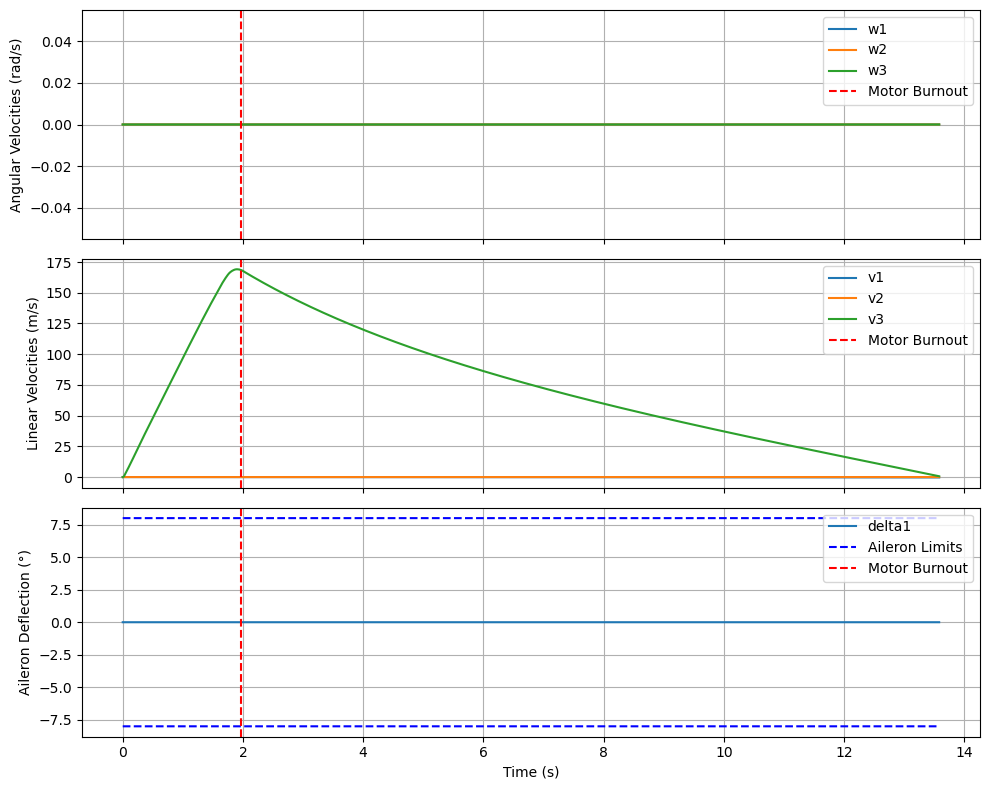

In [20]:
xhat = np.array(controller.states)
u = np.array(controller.inputs)
t = np.arange(0, xhat.shape[0]*controller.dt, controller.dt)

import matplotlib.pyplot as plt
fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
axs[0].plot(t, xhat[:, 0], label='w1')
axs[0].plot(t, xhat[:, 1], label='w2')
axs[0].plot(t, xhat[:, 2], label='w3')
axs[0].axvline(controller.t_motor_burnout, color='r', linestyle='--', label='Motor Burnout')
axs[0].set_ylabel('Angular Velocities (rad/s)')
axs[0].legend()
axs[0].grid()
axs[1].plot(t, xhat[:, 3], label='v1')
axs[1].plot(t, xhat[:, 4], label='v2')
axs[1].plot(t, xhat[:, 5], label='v3')
axs[1].axvline(controller.t_motor_burnout, color='r', linestyle='--', label='Motor Burnout')
axs[1].set_ylabel('Linear Velocities (m/s)')
axs[1].legend()
axs[1].grid()
axs[2].plot(t, u * 180/np.pi, label='delta1')
axs[2].plot(t, -8 * np.ones_like(u), 'b--', label='Aileron Limits')
axs[2].plot(t, 8 * np.ones_like(u), 'b--')
axs[2].axvline(controller.t_motor_burnout, color='r', linestyle='--', label='Motor Burnout')
axs[2].set_ylabel('Aileron Deflection (°)')
axs[2].set_xlabel('Time (s)')
axs[2].legend()
axs[2].grid()
plt.tight_layout()

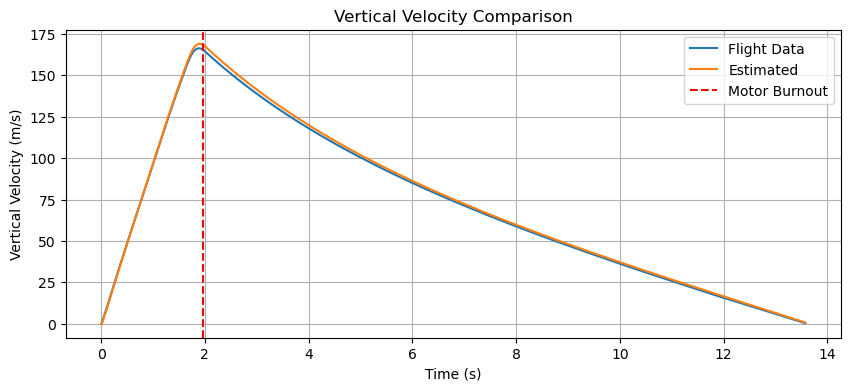

In [25]:
v3 = pd.read_csv(controller.csv_path)["Vertical velocity (m/s)"]
t = pd.read_csv(controller.csv_path)["# Time (s)"]
mask = t <= controller.t_estimated_apogee
v3 = v3[mask]
t = t[mask]
plt.figure(figsize=(10,4))
plt.plot(t, v3, label='Flight Data')
plt.plot(np.arange(0, xhat.shape[0]*controller.dt, controller.dt), xhat[:, 5], label='Estimated')
plt.axvline(controller.t_motor_burnout, color='r', linestyle='--', label='Motor Burnout')
plt.xlabel('Time (s)')
plt.ylabel('Vertical Velocity (m/s)')
plt.title('Vertical Velocity Comparison')
plt.legend()
plt.grid()

## Sensor Testing

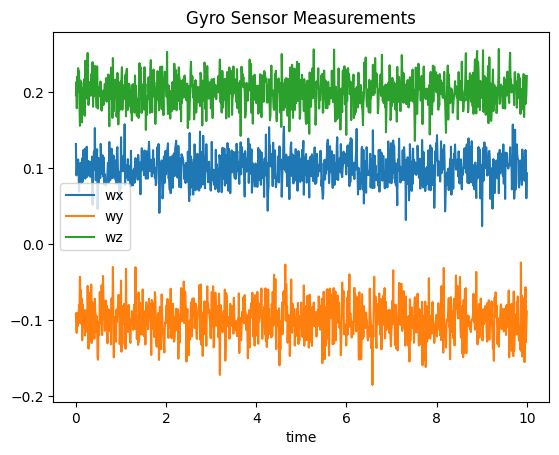

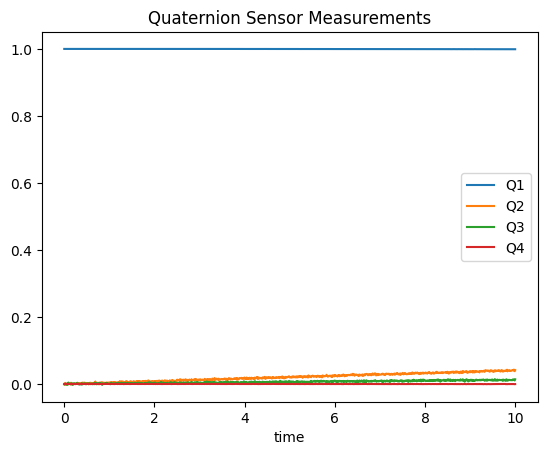

In [ ]:
import matplotlib.pyplot as plt

controler = Controls()
time = np.linspace(0,10,1000)
measurements = []
for t in time:
    m = controler.deriveSensorModels(t,0.1,-0.1,0.2,0,0,0)
    measurements.append(m)
measurements = np.array(measurements)
plt.plot(time, measurements[:,0],label = "wx")
plt.plot(time, measurements[:,1],label = "wy" )
plt.plot(time, measurements[:,2],label = "wz")
plt.title("Gyro Sensor Measurements")
plt.legend()
plt.xlabel("time")
plt.show()

plt.plot(time, measurements[:,3],label = "Q1")
plt.plot(time, measurements[:,4],label = "Q2")
plt.plot(time, measurements[:,5],label = "Q3")

plt.plot(time, measurements[:,6],label = "Q4")
plt.title("Quaternion Sensor Measurements")
plt.xlabel("time")
plt.legend()

plt.show()

## Angle of attack calculation bogus

In [6]:
import numpy as np
from scipy.optimize import fsolve

# 1. Define the input variables (v, v_dot, theta, phi)
# These will be fixed numerical values for a specific problem instance.
v1, v2, v3 = 1.0, 1.0, 100.0  # Example values for v (in m/s)
vdot1, vdot2, vdot3 = 0.2, 0.3, 4.0 * 9.81
theta = np.deg2rad(45.0)  # Example value for theta (in radians)
phi = np.deg2rad(45.0)    # Example value for phi (in radians)

# 2. Calculate the Constant A
def calculate_A(v1, v2, v3, vdot1, vdot2, vdot3):
    # Numerator: Magnitude of the cross product |v x v_dot|
    num_sq = (v1*vdot2 - v2*vdot1)**2 + \
             (v1*vdot3 - v3*vdot1)**2 + \
             (v2*vdot3 - v3*vdot2)**2
    num = np.sqrt(num_sq)
    
    # Denominator: Magnitude of |v|
    den = np.sqrt(v1**2 + v2**2 + v3**2)
    
    # Handle division by zero case (if |v| is zero)
    if den == 0:
        return 0.0 
    return num / den

A = calculate_A(v1, v2, v3, vdot1, vdot2, vdot3)

# 3. Define the Function f(alpha) = 0
def f_alpha(alpha, A, vdot1, vdot2, vdot3, theta, phi):
    cos_a = np.cos(alpha)
    sin_a = np.sin(alpha)
    
    # Denominator terms squared (N_i^2)
    N1_sq = (vdot1 + A * sin_a * np.cos(theta))**2
    N2_sq = (vdot2 + A * sin_a * np.cos(phi))**2
    N3_sq = (vdot3 - A * cos_a)**2
    
    # Full Denominator
    D_full = np.sqrt(N1_sq + N2_sq + N3_sq)
    
    # Check for singularity (D_full close to zero)
    if D_full == 0:
        # In a real scenario, you'd need better handling here.
        # Returning a very large number forces the solver away.
        return 1e9 

    LHS = (vdot3 - A * cos_a) / D_full
    
    # f(alpha) = LHS - cos(alpha)
    return LHS - cos_a

# 4. Solve for alpha
# Provide an initial guess (x0). Since alpha is typically between 0 and pi, 
# a guess of 0 or pi/2 (1.57 rad) is often a good start.
initial_guess = np.pi / 2  # 90 degrees
    
# fsolve finds the root (value of alpha where f_alpha = 0)
alpha_solution = fsolve(f_alpha, initial_guess, 
                        args=(A, vdot1, vdot2, vdot3, theta, phi))

# Convert to degrees for readability
alpha_degrees = np.rad2deg(alpha_solution[0])

print(f"The constant A is: {A:.4f}")
print(f"The solved angle alpha is: {alpha_degrees:.4f} degrees")

# Verification: f(alpha) should be close to zero
print(f"Verification f(alpha) = {f_alpha(alpha_solution[0], A, vdot1, vdot2, vdot3, theta, phi):.2e}")

The constant A is: 0.2134
The solved angle alpha is: 0.5322 degrees
Verification f(alpha) = 0.00e+00


In [7]:
v1, v2, v3 = 1.0, 1.0, 100.0  # Example values for v (in m/s)
vdot1, vdot2, vdot3 = 0.2, 0.3, 4.0 * 9.81
theta = np.deg2rad(45.0)  # Example value for theta (in radians)
phi = np.deg2rad(45.0)    # Example value for phi (in radians)

eqn = (vdot3 - sqrt((v1*vdot2 - v2*vdot1)**2 + (v1*vdot3 - v3*vdot1)**2 + (v2*vdot3 - v3*vdot2)**2)*cos(alpha)/sqrt(v1**2 + v2**2 + v3**2))/sqrt(Abs(vdot1 + sqrt((v1*vdot2 - v2*vdot1)**2 + (v1*vdot3 - v3*vdot1)**2 + (v2*vdot3 - v3*vdot2)**2)*sin(alpha)*cos(theta)/sqrt(v1**2 + v2**2 + v3**2))**2 + Abs(vdot2 + sqrt((v1*vdot2 - v2*vdot1)**2 + (v1*vdot3 - v3*vdot1)**2 + (v2*vdot3 - v3*vdot2)**2)*sin(alpha)*cos(phi)/sqrt(v1**2 + v2**2 + v3**2))**2 + Abs(vdot3 - sqrt((v1*vdot2 - v2*vdot1)**2 + (v1*vdot3 - v3*vdot1)**2 + (v2*vdot3 - v3*vdot2)**2)*cos(alpha)/sqrt(v1**2 + v2**2 + v3**2))**2) - cos(alpha)

x0 = 0.5322 # Initial guess for alpha in radians
eqn1 = diff(eqn, alpha)
while eqn.subs(alpha, x0) > 1e-6:
    f = eqn.subs(alpha, x0)
    f1 = eqn1.subs(alpha, x0)
    x0 = x0 - f/f1
    print(x0)

x = 0.00928934316054106
eqn.subs(alpha, x)

0.259747405800996
0.129330001187933
0.0649306283209259
0.0331369270526659
0.0178817723421866
0.0113587724080490
0.00947778020883919
0.00929015344005838


1.01137846986177e-8

# TODO:
1. Update aileron.stl to 4 separate aileron files that are placed in the correct positions, currently only one aileron is in correct position and all other Aileron.stl file placements overlap [DONE]
2. Test with two ailerons (left and right), see if they are in correct positions [DONE]
3. Define them as joints in rocket.urdf, apply changes to update_meshcat() as shown in Copilot Chat shown below [IP]
4. Test if these ailerons are controllable 
5. Add other 2 ailerons in following similar process, define them in ae353_zag.py file in meshcat_init() and meshcat_update()
6. Test if these ailerons are controllable


**Question**: if i define the aileron as joints, how can i control them if meshcat doesn't do any updates on it manually?

Great question!  
When you define the ailerons as joints in your URDF, **you control them through PyBullet, not Meshcat**.

### How it works:

- **PyBullet** simulates the physics and joint positions.
- **Meshcat** is just a visualizer. If you want Meshcat to show the ailerons moving, you must update their transforms in your `meshcat_update` method, using the joint states from PyBullet.

---

## How to Control Aileron Joints in PyBullet

1. **Set the joint positions in PyBullet:**
   ```python
   self.bullet_client.setJointMotorControl2(
       self.robot_id,
       jointIndex,  # index of the aileron joint
       self.bullet_client.POSITION_CONTROL,
       targetPosition=desired_angle
   )
   ```
   - You can get the joint indices by name using `getJointInfo`.

2. **Update Meshcat visualization:**
   - In your `meshcat_update` method, get the joint state from PyBullet:
     ```python
     joint_state = self.bullet_client.getJointState(self.robot_id, jointIndex)
     joint_angle = joint_state[0]
     ```
   - Use this angle to set the transform of the aileron mesh in Meshcat:
     ```python
     # Compute the transform for the aileron based on joint_angle
     self.vis['robot']['aileron-right'].set_transform(...)
     ```

---

## Summary Table

| What controls the joint? | How to update?                      |
|------------------------- |-------------------------------------|
| PyBullet                 | `setJointMotorControl2`             |
| Meshcat                  | Use joint state to set transform    |

---

**In short:**  
- PyBullet controls the joint angles.
- Meshcat only visualizes; you must update the transforms in your code using the joint angles from PyBullet.

Let me know if you want a code example for your specific setup!

In [1]:
# These modules are part of other existing libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg
from sympy import *

# This is my own script (it is an interface to the pybullet simulator)
import rocket_424

simulator = rocket_424.Simulator(
    display=True,  # Whether or not to show the simulation window. The simulation will
    # run much faster if you do not show this window, so set display to
    # False if you want to run many simulations to collect results.
)

simulator.camera_catview()

pybullet build time: Sep  3 2024 12:57:43


argv[0]=
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/


In [2]:
class Controller:
    def __init__(self):
        pass
    def reset(self):
        pass

    def run(
        self,
        t,  # current time
        p_x,
        p_y,
        p_z,  # components of position (+z is down!)
        psi,
        theta,
        phi,  # yaw, pitch, and roll angles
        v_x,
        v_y,
        v_z,  # components of linear velocity in the body frame
        w_x,
        w_y,
        w_z,  # components of angular velocity in the body frame
    ):

        # FIXME: replace the following lines
        # x = np.array([p_y, psi, theta, phi, v_x, v_y, v_z, w_x, w_y, w_z])
        # x_d = -self.K @ x
        # delta_r = x_d[0]  # right elevon deflection angle (positive is down)
        # delta_l = x_d[1]  # left elevon deflection angle (positive is down)

        # Run the simulation with outputs from data provided by control algorithm from other file in Control
        delta_1 = 0.0
        delta_2 = 0.0
        delta_3 = 0.0
        delta_4 = 0.0
        return delta_1, delta_2, delta_3, delta_4

In [3]:
controller = Controller()
controller.reset()
simulator.reset(
    initial_conditions = {
        'p_x': 0.,
        'p_y': 0.,
        'p_z': 0.,
        'psi': 0.,
        'theta': -np.pi/2,
        'phi': 0.,
        'v_x': 0.,
        'v_y': 0.,
        'v_z': -1.,
        'w_x': 0.,
        'w_y': 0.,
        'w_z': 0.,
    }
)

# num_iterations = 50

# for i in range(num_iterations):
#     controller = Controller(Q, R)
#     simulator.reset()
#     data = simulator.run(controller, maximum_time=25.0)
#     has_landed = simulator.has_landed()
#     if has_landed:
#         print(f"Iteration {i}: The aircraft landed.")
#         break
#     else:
#         print(f"Iteration {i}: The aircraft did not land.")

data = simulator.run(
    controller,  # <-- required (an instance of your Controller class)
    maximum_time=5.0,  # <-- optional (how long you want to run the simulation in seconds)
    data_filename=None,  # <-- optional (save data to this file, e.g., 'my_data.json')
    video_filename=None,  # <-- optional (save video to this file, e.g., 'my_video.mov')
)

AttributeError: 'Simulator' object has no attribute 'maximum_elevon_deflection'

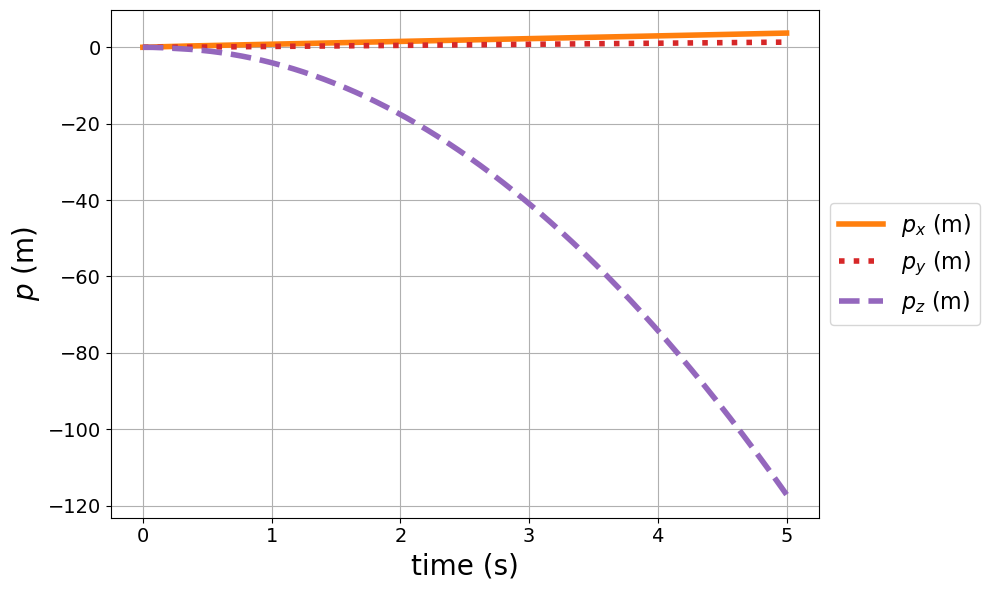

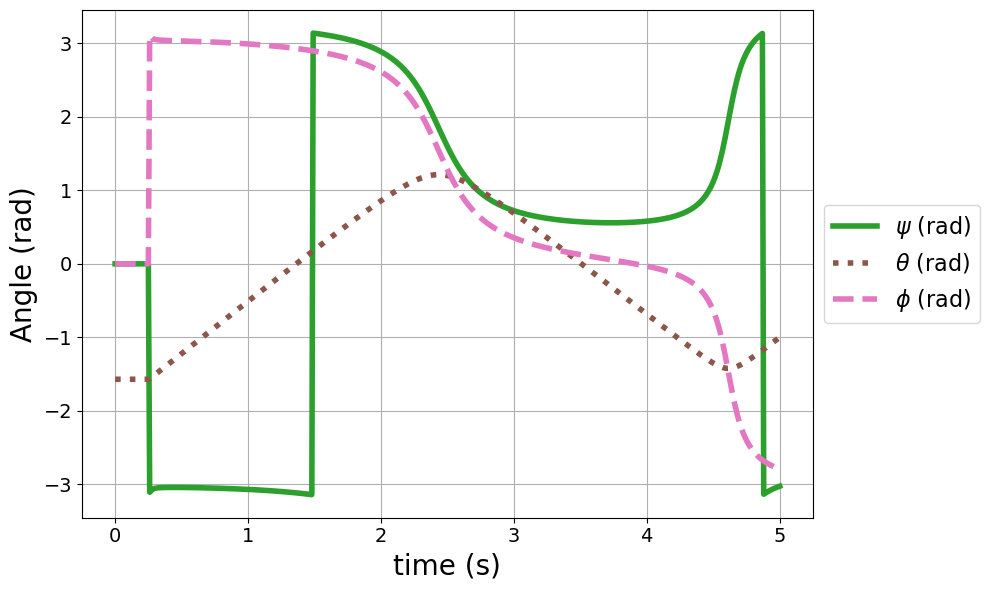

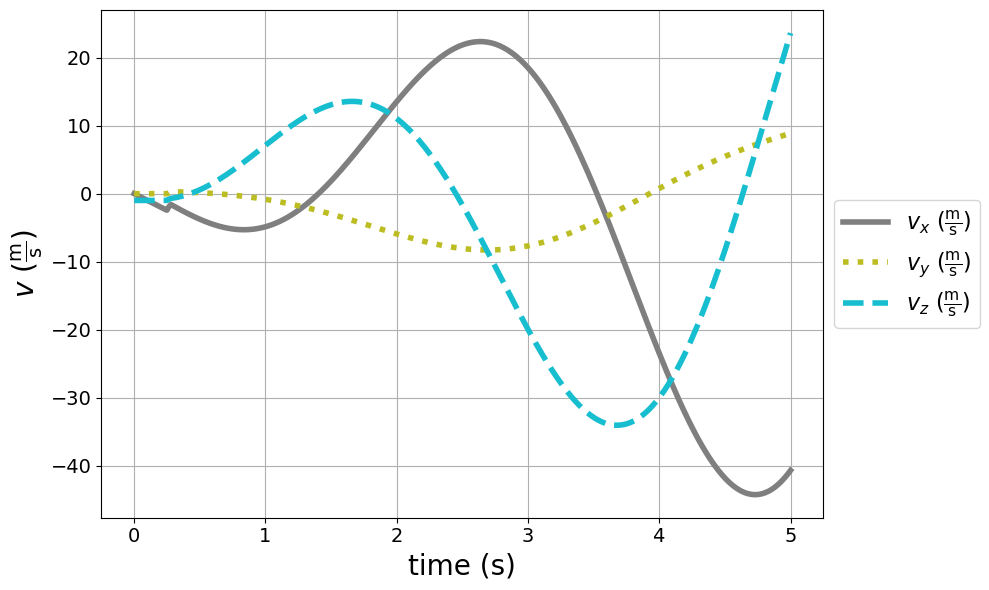

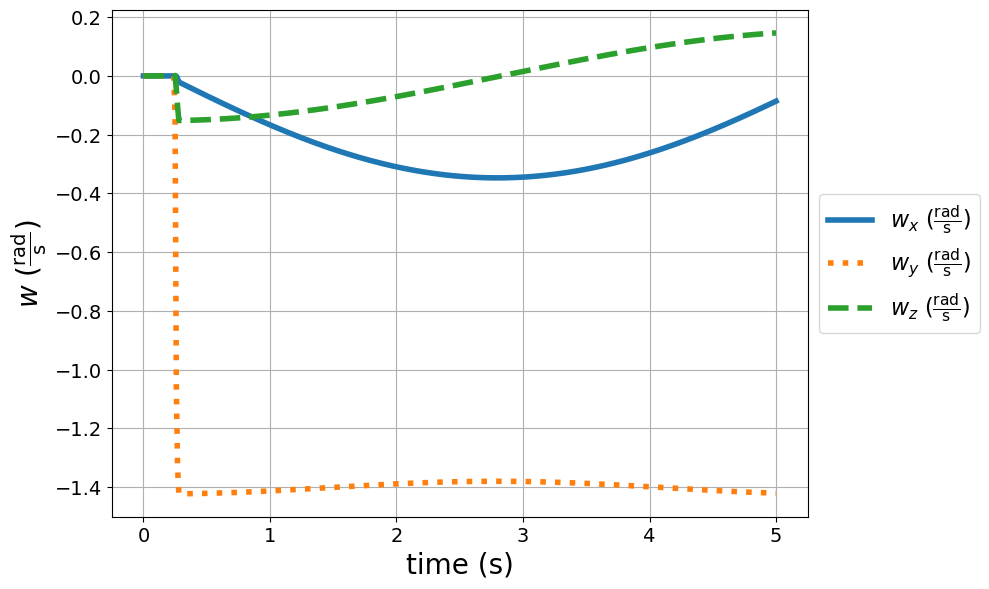

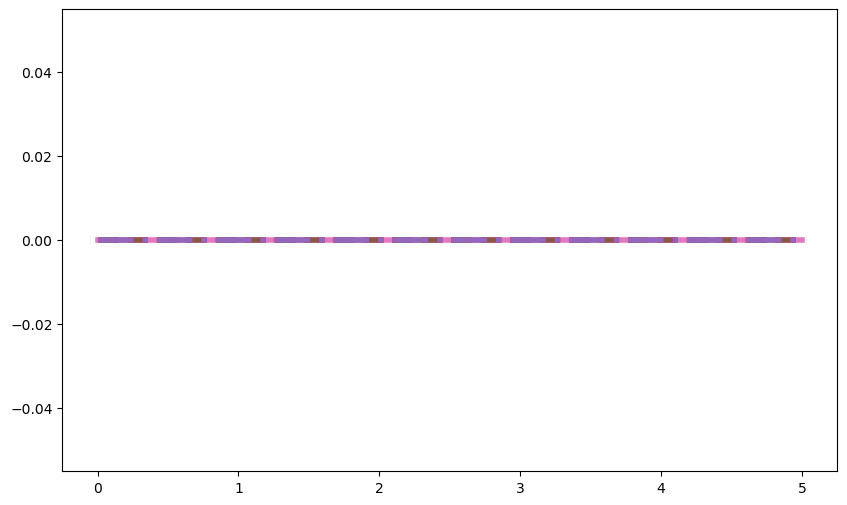

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming data is a dictionary containing your data
# Example: data = {"t": ..., "p_x": ..., "p_y": ..., "p_z": ..., "psi": ..., "theta": ..., "phi": ..., "v_x": ..., "v_y": ..., "v_z": ..., "w_x": ..., "w_y": ..., "w_z": ..., "delta_r": ..., "delta_l": ...}

# Plot position
fig_pos, ax_pos = plt.subplots(figsize=(10, 6))
ax_pos.plot(data["t"], data["p_x"], label="$p_x$ (m)", linewidth=4, color="C1", linestyle="solid")
ax_pos.plot(data["t"], data["p_y"], label="$p_y$ (m)", linewidth=4, color="C3", linestyle="dotted")
ax_pos.plot(data["t"], data["p_z"], label="$p_z$ (m)", linewidth=4, color="C4", linestyle="--")
ax_pos.grid()
ax_pos.set_ylabel("$p$ (m)", fontsize=20)
ax_pos.set_xlabel("time (s)", fontsize=20)
ax_pos.legend(fontsize=16, loc="center left", bbox_to_anchor=(1, 0.5))
ax_pos.tick_params(labelsize=14)
fig_pos.tight_layout()
fig_pos.savefig("position_plot.png", facecolor="white", transparent=False)

# Plot orientation
fig_ori, ax_ori = plt.subplots(figsize=(10, 6))
ax_ori.plot(data["t"], data["psi"], label="$\\psi$ (rad)", linewidth=4, color="C2", linestyle="solid")
ax_ori.plot(data["t"], data["theta"], label="$\\theta$ (rad)", linewidth=4, color="C5", linestyle="dotted")
ax_ori.plot(data["t"], data["phi"], label="$\\phi$ (rad)", linewidth=4, color="C6", linestyle="--")
ax_ori.grid()
ax_ori.set_ylabel("Angle (rad)", fontsize=20)
ax_ori.set_xlabel("time (s)", fontsize=20)
ax_ori.legend(fontsize=16, loc="center left", bbox_to_anchor=(1, 0.5))
ax_ori.tick_params(labelsize=14)
fig_ori.tight_layout()
fig_ori.savefig("orientation_plot.png", facecolor="white", transparent=False)

# Plot linear velocity
fig_linvel, ax_linvel = plt.subplots(figsize=(10, 6))
ax_linvel.plot(data["t"], data["v_x"], label="$v_x\\ (\\frac {\\text{m}} {\\text{s}})$", linewidth=4, color="C7", linestyle="solid")
ax_linvel.plot(data["t"], data["v_y"], label="$v_y\\ (\\frac {\\text{m}} {\\text{s}})$", linewidth=4, color="C8", linestyle="dotted")
ax_linvel.plot(data["t"], data["v_z"], label="$v_z\\ (\\frac {\\text{m}} {\\text{s}})$", linewidth=4, color="C9", linestyle="--")
ax_linvel.grid()
ax_linvel.set_ylabel("$v\\ (\\frac {\\text{m}} {\\text{s}})$", fontsize=20)
ax_linvel.set_xlabel("time (s)", fontsize=20)
ax_linvel.legend(fontsize=16, loc="center left", bbox_to_anchor=(1, 0.5))
ax_linvel.tick_params(labelsize=14)
fig_linvel.tight_layout()
fig_linvel.savefig("linear_velocity_plot.png", facecolor="white", transparent=False)

# Plot angular velocity
fig_angvel, ax_angvel = plt.subplots(figsize=(10, 6))
ax_angvel.plot(data["t"], data["w_x"], label="$w_x\\ (\\frac {\\text{rad}} {\\text{s}})$", linewidth=4, color="C10", linestyle="solid")
ax_angvel.plot(data["t"], data["w_y"], label="$w_y\\ (\\frac {\\text{rad}} {\\text{s}})$", linewidth=4, color="C11", linestyle="dotted")
ax_angvel.plot(data["t"], data["w_z"], label="$w_z\\ (\\frac {\\text{rad}} {\\text{s}})$", linewidth=4, color="C12", linestyle="--")
ax_angvel.grid()
ax_angvel.set_ylabel("$w\\ (\\frac {\\text{rad}} {\\text{s}})$", fontsize=20)
ax_angvel.set_xlabel("time (s)", fontsize=20)
ax_angvel.legend(fontsize=16, loc="center left", bbox_to_anchor=(1, 0.5))
ax_angvel.tick_params(labelsize=14)
fig_angvel.tight_layout()
fig_angvel.savefig("angular_velocity_plot.png", facecolor="white", transparent=False)

# Plot elevon deflection angles
fig_delta, ax_delta = plt.subplots(figsize=(10, 6))
ax_delta.plot(data["t"], data["delta_1_command"], label="$\\delta_r$ (rad)", linewidth=4, color="C16", linestyle="solid")
ax_delta.plot(data["t"], data["delta_2_command"], label="$\\delta_l$ (rad)", linewidth=4, color="C15", linestyle="--")
ax_delta.plot(data["t"], data["delta_3_command"], label="$\\delta_3$ (rad)", linewidth=4, color="C13", linestyle="dotted")
ax_delta.plot(data["t"], data["delta_4_command"], label="$\\delta_4$ (rad)", linewidth=4, color="C14", linestyle="dashdot")
ax_delta.plot(data["t"], -np.ones_like(data["t"]) * simulator.maximum_elevon_deflection, ":", linewidth=4, color="C4", zorder=0, label="Max deflection")
ax_delta.plot(data["t"], np.ones_like(data["t"]) * simulator.maximum_elevon_deflection, ":", linewidth=4, color="C4", zorder=0)
ax_delta.grid()
ax_delta.set_ylabel("$\\delta$ (rad)", fontsize=20)
ax_delta.set_xlabel("time (s)", fontsize=20)
ax_delta.legend(fontsize=16, loc="center left", bbox_to_anchor=(1, 0.5))
ax_delta.tick_params(labelsize=14)
ax_delta.set_ylim(-1.2 * simulator.maximum_elevon_deflection, 1.2 * simulator.maximum_elevon_deflection)
fig_delta.tight_layout()
fig_delta.savefig("elevon_deflection_plot.png", facecolor="white", transparent=False)